In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [2]:
%reload_ext autoreload
%autoreload 2

import gc, math, traceback, datetime

import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from datasets import load_from_disk

import whisper
from whisper.tokenizer import get_tokenizer

from utils import audio, gradient, gpu

# Load model and data

In [3]:
test = load_from_disk("../tedlium/test.hf").with_format("torch").select(range(100))
train = load_from_disk("../tedlium/train.hf").with_format("torch").select(range(100))

# wave = test[0]["audio"]

Loading dataset from disk:   0%|          | 0/109 [00:00<?, ?it/s]

In [4]:
device = gpu.get_device()

model = whisper.load_model("tiny.en").to(device)
# cache, hooks = model.install_kv_cache_hooks()
target_id, sot_ids = gradient._get_ids(model)

Device: cuda


/home/jovyan/libs/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


In [5]:
model.eval();

# Model and Audio Generation

In [6]:
def shakedrop_hooks(mode, uni_dist, b_dist):
    assert mode in ["fwd", "bwd", "test"]
    def hook(module, x, output):
        x = x[0]
        b_l = b_dist.sample()
        alpha = uni_dist.sample()
        beta = uni_dist.sample()
        return output
        if mode == "fwd":
            return x + (b_l + alpha - b_l * alpha) * output
        elif mode == "bwd":
            return x + (b_l + beta - b_l * beta) * output
        else:
            return x + (b_dist.mean + uni_dist.mean - b_dist.mean * uni_dist.mean) * output
    return hook

In [7]:
def generate_hooks(model_limit, model_layers):
    hooks = []
    uni, b = torch.distributions.uniform.Uniform(0, 1), torch.distributions.bernoulli.Bernoulli(0.4)
    for _ in range(model_limit):
        temp_fwd, temp_bwd, temp_test = [], [], []
        temp = {}
        for _ in range(model_layers):
            temp_fwd.append(shakedrop_hooks("fwd", uni, b))
            temp_bwd.append(shakedrop_hooks("bwd", uni, b))
            temp_test.append(shakedrop_hooks("test", uni, b))
        temp["fwd"], temp["bwd"], temp["test"] = temp_fwd, temp_bwd, temp_test
        hooks.append(temp)
    return hooks

In [8]:
MODEL_LIMIT = 5
MODEL_LAYERS = len(model.encoder.blocks + model.decoder.blocks)

hooks = generate_hooks(MODEL_LIMIT, MODEL_LAYERS)

In [9]:
def generate_data(adv_audio, delta, data_limit):
    result = []
    for _ in range(data_limit):
        result.append(adv_audio + torch.randn(adv_audio.shape).to(adv_audio.device) * delta)
    return torch.stack(result)

In [10]:
DATA_LIMIT = 10
DELTA = 0.5

# data = generate_data(wave, DELTA, DATA_LIMIT)

# Training Loop

In [11]:
def forward(model: whisper.model.Whisper, audio, sot_ids, target_id: int):
    audio = audio.to(model.device)
    mel = gradient.audio_to_mel_batch(audio)
    logits = gradient.mel_to_logits_batch(model, mel, sot_ids)[:,-1,:].squeeze(dim=1)
    loss = gradient.get_loss_batch(logits, target_id)
    return loss

def mel_to_logits_batch(model: whisper.model.Whisper, mel_batch, sot_ids):
    sot_ids = sot_ids.unsqueeze(0).expand(mel_batch.size(0), -1).to(model.device)
    return model.forward(mel_batch, sot_ids)

In [12]:
def register_hooks_on_model(model, hooks, mode):
    assert mode in ["fwd", "bwd", "test"]
    handles = []
    layers = model.encoder.blocks + model.decoder.blocks
    for i, h in enumerate(hooks[mode]):
        if mode == "bwd":
            han = layers[i].register_backward_hook(h)
        else:
            han = layers[i].register_forward_hook(h)
        handles.append(han)
    return handles

def unregister_hooks_on_model(handles):
    for h in handles:
        h.remove()

In [13]:
import tqdm
import traceback

def loop(model, adv_audio, train_dataset, hooks, sot_ids, target_id, iters, mu, grad_mask, clamp_epsilon, lr):
    try:
        g_t = 0.0
        g_st = g_wt = None
        loss = white_box_loss = None
        adv_audio = adv_audio.to(model.device)
        benchmark_example = train[0]["audio"].to(model.device).unsqueeze(0)
        fwd_handles = bwd_handles = None
        pbar = tqdm.tqdm(range(iters), leave=True, ncols=0)
        for i in pbar:
            if i != 0 and i % 5 == 0:
                lr *= 0.75
            g_st = iter_loss = 0.0

            pbar.set_postfix_str("Calculating white box loss")
            adv_audio.requires_grad = True
            white_box_loss = forward(model, torch.cat([adv_audio, benchmark_example], dim=1), sot_ids, target_id)
            white_box_loss.backward()
            g_wt = adv_audio.grad.to(model.device)
            adv_audio.requires_grad = False

            pbar.set_postfix_str("Generating data")
            data = generate_data(adv_audio, DELTA, DATA_LIMIT).squeeze().detach()
            dataset = DataLoader(data, batch_size=1)
            
            for data_idx, d in enumerate(dataset):
                d = d.to(model.device)
                if not d
                d.requires_grad = True
                
                for model_idx, m in enumerate(hooks):                                     
                    for batch_idx, b in enumerate(train_dataset):
                        pbar.set_postfix_str(f"Current: Data {data_idx + 1}/{len(dataset)} | Model {model_idx + 1}/{len(hooks)} | Train Batch {batch_idx + 1}/{len(train_dataset)}")
                        fwd_handles = register_hooks_on_model(model, m, "fwd")
                        b = b.to(model.device)
                        d_stacked = d.repeat(b.size(0), 1)
                        loss = forward(model, torch.cat([d_stacked, b], dim=1), sot_ids, target_id)
                        iter_loss += loss.detach().cpu().item()
                        unregister_hooks_on_model(fwd_handles)

                        bwd_handles = register_hooks_on_model(model, m, "bwd")
                        loss.backward()
                        unregister_hooks_on_model(bwd_handles)

                        g_st += torch.sum(d.grad, dim=0)

                d.grad.zero_()
                d.requires_grad = False
                d.cpu()

            pbar.set_postfix_str("Updating adv_data")
            g_st *= 1 / (MODEL_LIMIT * DATA_LIMIT)
            mask = (torch.rand(g_wt.shape) < grad_mask).float().to(model.device)
            g_t = mu * g_t + (mask * g_wt + g_st) / torch.abs(mask * g_wt + g_st)
            sign = torch.where(g_t > 0, 1, -1).to(device)
            adv_audio = (adv_audio - lr * sign).clamp(min=-clamp_epsilon, max=clamp_epsilon)
            
            pbar.write(f"White box loss: {white_box_loss} | Iteration loss: {iter_loss / (len(hooks) * len(dataset) * len(train_dataset))}")
    except Exception as e:
        traceback.print_exc()
    finally:
        if fwd_handles:
            unregister_hooks_on_model(fwd_handles)
            fwd_handles.clear()
        if bwd_handles:
            unregister_hooks_on_model(bwd_handles)
            bwd_handles.clear()
        if loss:
            del loss
        if white_box_loss is not None:
            del white_box_loss
        if g_st is not None:
            del g_st
        if g_wt is not None:
            del g_wt
        
        gc.collect()
        torch.cuda.empty_cache()
        gpu.print_cuda_usage()
        return adv_audio.detach().cpu()

In [14]:
snippet = torch.rand((1, 10240))

In [15]:
from torch.utils.data import DataLoader 
def collate(ls):
    return ls[0]["audio"].unsqueeze(0)
test_dataset = DataLoader(test)
train_dataset = DataLoader(train, batch_size=20, collate_fn=collate)

In [16]:
from utils.attacks import PrepareFront
# gradient.evaluate(model, snippet, PrepareFront((1, 1600)), dataset, 0.005, 0)

In [17]:
adv_snippet = loop(model, snippet, train_dataset, hooks, sot_ids, target_id, iters=30, mu=0.9, grad_mask=0.0, clamp_epsilon=0.005, lr=1)

  3% 1/30 [01:09<33:35, 69.49s/it, Generating data]                          

White box loss: 8.820366859436035 | Iteration loss: 8.733935947418212


  7% 2/30 [02:14<31:14, 66.96s/it, Current: Data 1/10 | Model 1/5 | Train Batch 2/5] 

White box loss: 8.688360214233398 | Iteration loss: 8.642768926620484


 10% 3/30 [03:18<29:32, 65.66s/it, Generating data]                                  

White box loss: 8.734025955200195 | Iteration loss: 8.622789793014526


 13% 4/30 [04:18<27:21, 63.14s/it, Current: Data 1/10 | Model 1/5 | Train Batch 2/5] 

White box loss: 8.598867416381836 | Iteration loss: 8.605182180404663


 17% 5/30 [05:18<25:54, 62.20s/it, Current: Data 1/10 | Model 1/5 | Train Batch 1/5] 

White box loss: 8.832133293151855 | Iteration loss: 8.642843122482299


 20% 6/30 [06:19<24:38, 61.62s/it, Generating data]                                  

White box loss: 8.752519607543945 | Iteration loss: 8.636240825653076


 23% 7/30 [07:23<23:55, 62.40s/it, Current: Data 1/10 | Model 1/5 | Train Batch 1/5] 

White box loss: 8.708740234375 | Iteration loss: 8.590551710128784


 27% 8/30 [08:22<22:33, 61.53s/it, Current: Data 1/10 | Model 1/5 | Train Batch 1/5] 

White box loss: 8.663551330566406 | Iteration loss: 8.624800338745118


 27% 8/30 [08:42<23:56, 65.30s/it, Current: Data 4/10 | Model 2/5 | Train Batch 2/5]


0.409637451171875 GB


In [18]:
gradient.evaluate(model, adv_snippet, PrepareFront((1, 1600)), test_dataset, 0.005, 0)

Clamp: 0.005
Prepare Method: prepare_front
Snippet Size: (1, 1600)
Position: 0


Inference: 100%|██████████| 100/100 [00:36<00:00,  2.73it/s, Valid Examples: 97 | Empty Sequences: 0 | Total SL: 18165 | Non_empty ASL: 187.2680412371134]



Total valid examples: 97
Success rate (Empty): 0.0
Success rate (ASL): 187.2680412371134 (attacked) out of 187.84536082474227 (original)


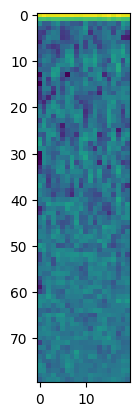

In [19]:
import matplotlib.pyplot as plt

plt.imshow(gradient.audio_to_mel(snippet).squeeze()[:, :20])

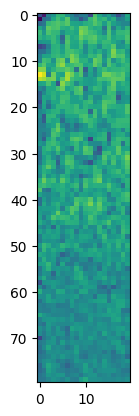

In [20]:
plt.imshow(gradient.audio_to_mel(adv_snippet.cpu()).squeeze()[:, :20])

In [21]:
from utils import gpu

In [22]:
gc.collect()
torch.cuda.empty_cache()
gpu.print_cuda_usage()

0.2980194091796875 GB
